## BERT (Bidirectional Encoder Representations from Transformers)
-



#### BERT NLP Application
- Google Search
- Sentiment Analysis
- Language Translation
- Text Summarization
- Question Answering
- Highlighting paragraphs

### Pre-trained bert model
- **BERT-base**: This is the base version of BERT with 12 transformer layers, 768 hidden units, and 12 self-attention heads.

- **BERT-large**: BERT-large is a larger version of BERT with 24 transformer layers, 1024 hidden units, and 16 self-attention heads

- **BERT-cased**: BERT-cased retains the casing information of the original text during pre-training. This can be useful for tasks where capitalization plays a significant role, such as named entity recognition.

- **BERT-uncased**: BERT-uncased converts all text to lowercase during pre-training. It is suitable when the case information is less important for the specific NLP task.





### Reference
http://jalammar.github.io/illustrated-bert/

## Sentiment analysis using BERT

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.2 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
if torch.cuda.is_available():
    torch.device('cuda')
else:
    torch.device('cpu')

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ujjalkumarmaity/NLP/main/bert/reviews.csv',on_bad_lines='skip')
df = df[['content','score']]
def convert_sentiment(x):
    if x<=2:
        return 0
    elif x==3:
        return 1
    else:
        return 2
df['sentiment'] = df.score.apply(convert_sentiment)
df.head(5)

,content,score,sentiment
0,I cannot open the app anymore,1,0
1,I have been begging for a refund from this app...,1,0
2,Very costly for the premium version (approx In...,1,0
3,"Used to keep me organized, but all the 2020 UP...",1,0
4,Dan Birthday Oct 28,1,0


<Axes: >

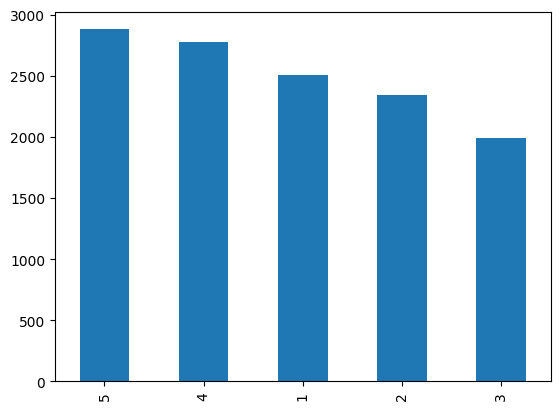

In [ ]:
df.score.value_counts().plot(kind='bar')

In [ ]:
df = df[['content','sentiment']]

### Preprocess Data

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# Construct a BERT tokenizer
tokenizer('let define the metrics you')

{'input_ids': [101, 1519, 9410, 1103, 12676, 1116, 1128, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# Converts a string to a sequence of ids (integer), using the tokenizer and vocabulary.
tokenizer.encode('let define the metrics you')

[101, 1519, 9410, 1103, 12676, 1116, 1128, 102]

In [ ]:
tokenizer.encode_plus("let define the metrics you")

{'input_ids': [101, 1519, 9410, 1103, 12676, 1116, 1128, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

### Prepare torch dataset

In [ ]:
class ReviewData(Dataset):
    def __init__(self,tokenizer,review,label,max_len):
        self.tokenizer = tokenizer
        self.review = review
        self.label = label
        self.max_len = max_len

    def __len__(self):
        return len(self.review)
    def __getitem__(self,ind):
        review = self.review[ind]
        label = self.label[ind]
        embed = self.tokenizer.encode_plus(review,
                                           add_special_tokens=True,
                                           max_length = self.max_len,
                                           return_attention_mask = True,
                                           return_token_type_ids=False,
                                           pad_to_max_length = True,
                                           return_tensors = 'pt')
        return {
            'review' : review,
            'input_ids' : embed['input_ids'].flatten(),
            'attention_mask':embed['attention_mask'].flatten(),
            'label' : torch.tensor(label,dtype = torch.long)
        }

In [ ]:
reviews = df.content.values
senttiment = df.sentiment.values
rd = ReviewData(tokenizer,reviews,senttiment,512)

In [ ]:
print('review text',rd[5]['review'])
print('input_ids shape',rd[5]['input_ids'].shape)
print('attention_mask shape',rd[5]['attention_mask'].shape)
print(rd[5]['label'])


review text It has changed how I viewed my different lists. Now they are all jumbled together and I can't find what I need.
input_ids shape torch.Size([512])
attention_mask shape torch.Size([512])
tensor(0)


**Split Data**

In [ ]:
train,test = train_test_split(df,test_size=0.3,random_state = 10)
test,val = train_test_split(test,test_size=0.4,random_state = 10)

**Create Pytorch DataLoader**

In [ ]:
def cerate_dataloader(df,tokenizer,max_len,batch_size):
    reviews = df.content.values
    senttiment = df.sentiment.values
    rd = ReviewData(tokenizer,reviews,senttiment,max_len)
    return DataLoader(rd,batch_size = batch_size)

In [ ]:
https://github.com/chriskhanhtran/bert-for-sentiment-analysis